In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mplcursors import cursor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import umap
from OpenAIService import OpenAIService
from tqdm import tqdm
import random
import json

# set random seed
random.seed(42)

openai_service = OpenAIService()

In [2]:
LOCATION_PROCESSED = 'data_processed'
ALL_SUBMISSIONS_FILENAME = f"{LOCATION_PROCESSED}/all_submissions_filtered_and_labbelled_and_embedded_pca.jsonl"

In [3]:
df_original = pd.read_json(ALL_SUBMISSIONS_FILENAME, lines=True)
print(f"Number of submissions: {len(df_original)}")

Number of submissions: 260882


In [4]:
# filter out submissions with title = [deleted by user]
df = df_original[df_original['title'] != '[deleted by user]']

# filter out submissions with selftext = [removed]
df = df[df['selftext'] != '[removed]']

In [5]:
# sample submissions
N_SAMPLES_ALL = 2_000
df_sample_all = df.sample(N_SAMPLES_ALL, random_state=42)
# reset index
df_sample_all.reset_index(drop=True, inplace=True)

In [6]:
CLUSTERS = 2
# kmeans clustering
kmeans = KMeans(n_clusters=CLUSTERS, random_state=0)
kmeans.fit(df_sample_all['embedding'].to_list())
df_sample_all['cluster'] = kmeans.labels_

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
def format_annotation(submission_row):
    MAX_BODY_WIDTH = 10
    MAX_BODY_LENGTH = 1000
    subreddit = submission_row['subreddit']
    score = submission_row['score']

    flair = submission_row['link_flair_text']

    annotation = f"{subreddit} - Score: {score} - Flair: {flair} - Cluster: {submission_row['cluster']}\n\n"

    title = f"{submission_row['title']}"
    # format title
    title = title.split()
    title = [title[i:i + MAX_BODY_WIDTH] for i in range(0, len(title), MAX_BODY_WIDTH)]
    title = [" ".join(line) for line in title]
    title = "\n".join(title)

    annotation += f"{title}"
    annotation += f"\n{len(title) * '-'}"

    selftext = submission_row['selftext']
    if not pd.isna(selftext):
        
        # body max width, otherwise make it multiline
        body = selftext.split()
        body = [body[i:i + MAX_BODY_WIDTH] for i in range(0, len(body), MAX_BODY_WIDTH)]
        body = [" ".join(line) for line in body]
        body = "\n".join(body)

        # truncate with ...
        if len(body) > MAX_BODY_LENGTH:
            body = body[:MAX_BODY_LENGTH] + "..."
        annotation += f"\n{body}"
    
    # escape dollar signs
    annotation = annotation.replace("$", "\$")

    return annotation

def select_annotation(sel, dataframe, alt_df=None):
    row = dataframe.iloc[sel.target.index]
    if alt_df is not None:
        data = dataframe["embedding_2d"].iloc[sel.target.index]
        sel_data = sel.target_.data
        if not np.array_equal(data, sel_data):
            row = alt_df.iloc[sel.target.index]
    
    sel.annotation.set_text(format_annotation(row))
    sel.annotation.get_bbox_patch().set_facecolor("black")  # Set background color to black
    sel.annotation.get_bbox_patch().set_alpha(0.9)          # Set background color transparency to 90%
    sel.annotation.set_fontsize(10)  # Set font size to 10
    # set text color to white
    sel.annotation.set_color("white")
    sel.annotation.get_bbox_patch().set_edgecolor("blue")  # Optionally, set border color
    sel.annotation.get_bbox_patch().set_linewidth(1.5)      # Optionally, set border width

# preforemat the annotations
df_sample_all['annotation'] = df_sample_all.apply(format_annotation, axis=1)


In [8]:
reducer = umap.UMAP(n_neighbors=75, n_components=2, random_state=42, metric='cosine')
embeddings_all = df_sample_all['embedding'].to_list()
# keep only the first 3 dimensions of the embeddings
embeddings_all = [embedding[:3] for embedding in embeddings_all]
embeddings_2d_all = reducer.fit_transform(embeddings_all)

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[1 0]
Number of advice seeking submissions: 1032
Index([2, 6, 7, 8, 9, 10, 12, 13, 14, 17], dtype='int64')


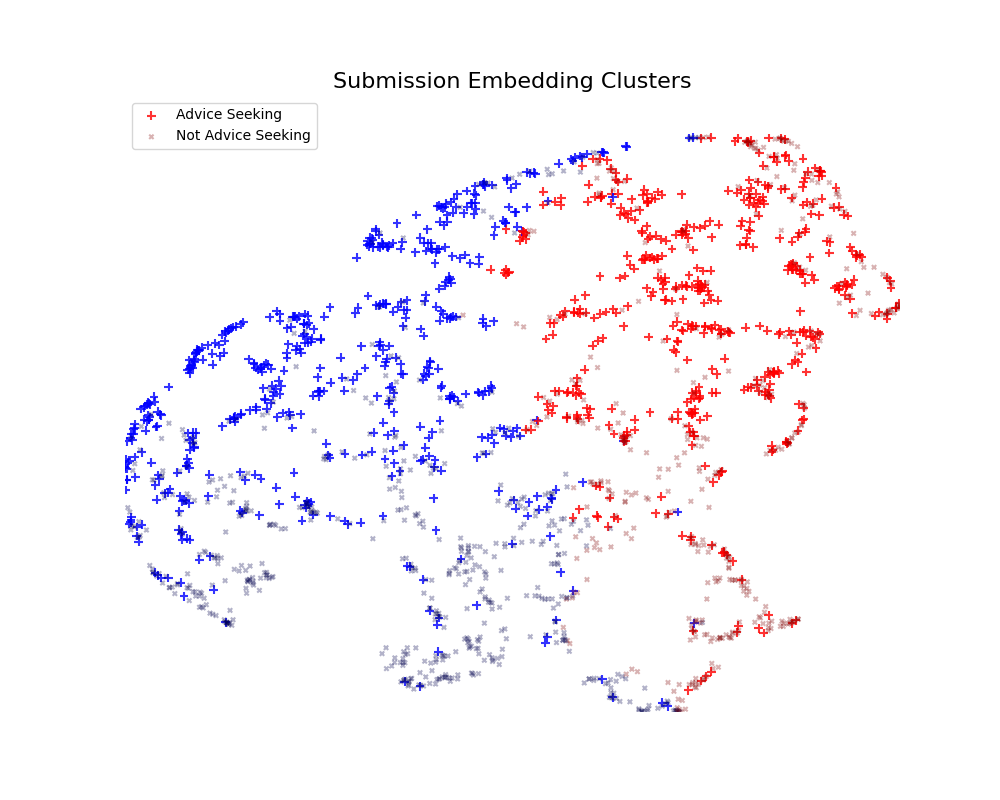

In [9]:
print(df_sample_all['cluster'].unique())

# visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# filter embeddings on is_advice_seeking
advice_seeking = df_sample_all[df_sample_all['is_advice_seeking'] == True]
not_advice_seeking = df_sample_all[df_sample_all['is_advice_seeking'] == False]

advice_seeking_idx = advice_seeking.index
print(f"Number of advice seeking submissions: {len(advice_seeking)}")
print(advice_seeking_idx[:10])
embeddings_2d_advice_seeking = embeddings_2d_all[advice_seeking_idx]
embeddings_2d_not_advice_seeking = np.delete(embeddings_2d_all, advice_seeking_idx, axis=0)

ax.scatter(embeddings_2d_advice_seeking[:, 0], embeddings_2d_advice_seeking[:, 1], c=advice_seeking['cluster'], s=40, alpha=0.8, marker='+', label='Advice Seeking', cmap='bwr')
ax.scatter(embeddings_2d_not_advice_seeking[:, 0], embeddings_2d_not_advice_seeking[:, 1], c=not_advice_seeking['cluster'], s=10, alpha=0.3, marker='x', label='Not Advice Seeking', cmap='seismic')

# lengend
ax.legend()

# ax.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], c=df_sample_all['cluster'], cmap='cool', s=4, alpha=0.3, marker='x')
ax.set_title("Submission Embedding Clusters", fontsize=16)
crs = cursor(ax, hover=True, highlight=True)

crs.connect("add", lambda sel: select_annotation(sel, df_sample_all))

# remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# zoom in to max and min
ax.set_xlim([np.min(embeddings_2d_all[:, 0]), np.max(embeddings_2d_all[:, 0])])
ax.set_ylim([np.min(embeddings_2d_all[:, 1]), np.max(embeddings_2d_all[:, 1])+ 1])

# save the plot
plt.savefig(f"{LOCATION_PROCESSED}/kmeans_clusters_submission_all.png")

plt.show()

In [10]:
# dendrogram
def plot_dendrogram(data, method='average', metric='cosine', filename=None):
    # calculate the linkage matrix
    Z = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(10, 8))
    plt.title("Dendrogram of Submission Embeddings", fontsize=16)

    dendrogram(Z, )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])

    # save the dendrogram if filename is provided
    if filename:
        plt.savefig(filename)

    plt.show()
    return Z

# plot_dendrogram(df_sample_all['embedding'].to_list(), filename=f"{LOCATION_PROCESSED}/dendrogram_all_submissions.png")

In [11]:
# sampling
N_SAMPLES = 10_000
KEEP_N_COMPONENTS = 3
FROM_N_COMPONENT = 0

df_advice_seeking = df_original[df_original['is_advice_seeking']]
print(f"Number of advice seeking posts: {len(df_advice_seeking)}")

# load data
df_advice_seeking = df_advice_seeking.sample(N_SAMPLES, random_state=42)
print(f"Number of advice seeking posts sampled: {N_SAMPLES}")

# reset index
df_advice_seeking.reset_index(drop=True, inplace=True)

# keep only the first 3 dimensions of the embeddings
print(f"Keeping only the first {KEEP_N_COMPONENTS} dimensions of the embeddings")
embeddings = df_advice_seeking['embedding'].to_list()
embeddings = [embedding[FROM_N_COMPONENT:FROM_N_COMPONENT+KEEP_N_COMPONENTS] for embedding in embeddings]
# set the embeddings
df_advice_seeking['embedding'] = embeddings

Number of advice seeking posts: 130268
Number of advice seeking posts sampled: 10000
Keeping only the first 3 dimensions of the embeddings


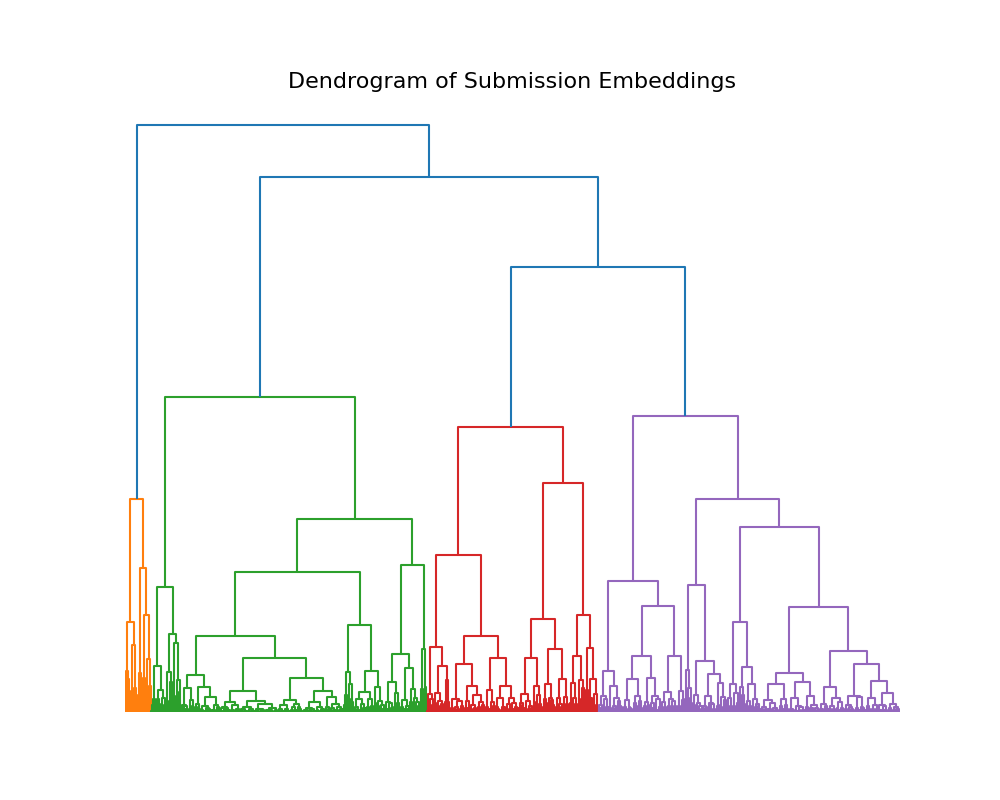

In [12]:
Z = plot_dendrogram(df_advice_seeking['embedding'].to_list(), filename=f"{LOCATION_PROCESSED}/dendrogram_advice_seeking.png")

In [13]:
clusters = 13
# kmeans clustering
# kmeans = KMeans(n_clusters=clusters, random_state=0)
# kmeans.fit(df_advice_seeking['embedding'].to_list())
# df_advice_seeking['cluster'] = kmeans.labels_

# agg clustering
# use cosine similarity
clustering = AgglomerativeClustering(n_clusters=clusters, affinity='cosine', linkage='average')

agg_clusters = clustering.fit_predict(df_advice_seeking['embedding'].to_list())

df_advice_seeking['cluster'] = agg_clusters

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [14]:
# umap 2d
reducer = umap.UMAP(n_neighbors=75, n_components=2, random_state=42, metric='cosine')
embeddings = df_advice_seeking['embedding'].to_list()
embeddings_2d = reducer.fit_transform(embeddings)
df_advice_seeking["embedding_2d"] = embeddings_2d.tolist()

/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
# find comments with keywords
KEYWORDS = ["Impuls", "Shopaholi", "Intervention", "ADHD", "Temu"]
# to lower case
df_advice_seeking['annotation'] = df_advice_seeking.apply(format_annotation, axis=1)
df_advice_seeking['has_keyword'] = df_advice_seeking['annotation'].apply(lambda x: any(keyword.lower() in x.lower() for keyword in KEYWORDS))
print(f"Number of comments with keywords: {len(df_advice_seeking[df_advice_seeking['has_keyword']])}")

# print the submission with the keyword
for idx, row in df_advice_seeking[df_advice_seeking['has_keyword']].iterrows():
    print(row['annotation'])
    print("\n\n")

Number of comments with keywords: 41
Anticonsumption - Score: 16 - Flair: Question/Advice? - Cluster: 12

Any tips on getting post guilt & improving?
-------------------------------------------
sorry if anything feels hard to read english isn’t my
first language & i have dyslexia ^_^; So I’ve been
2 months clean from overconsumption BUT whenever I see an
items that i purchased during my overconsumption phase I get
extremely guilty which is normal but Idk how to move
on…. This part is more of an explanation than making
excuses: a couple months back I was extremely depressed (still
am but it’s kinda shifted) and I spent a lot
of cash on buying stuff I didn’t really need both
from second hand shops but also from temu. if i
didn’t have a package coming or when i returned from
the city without buying anything i’d feel extremely bad, which
of course led me to buy more shit! now I’ve
gotten way better (deleted temu) and become way more mindful
when it comes to shopping overall :) Though it st

[[-4.243982315063477, 1.4149283170700073], [-3.3122379779815674, 6.489872932434082]]


/Users/adamlass/anaconda3/envs/reddit/lib/python3.10/site-packages/mplcursors/_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


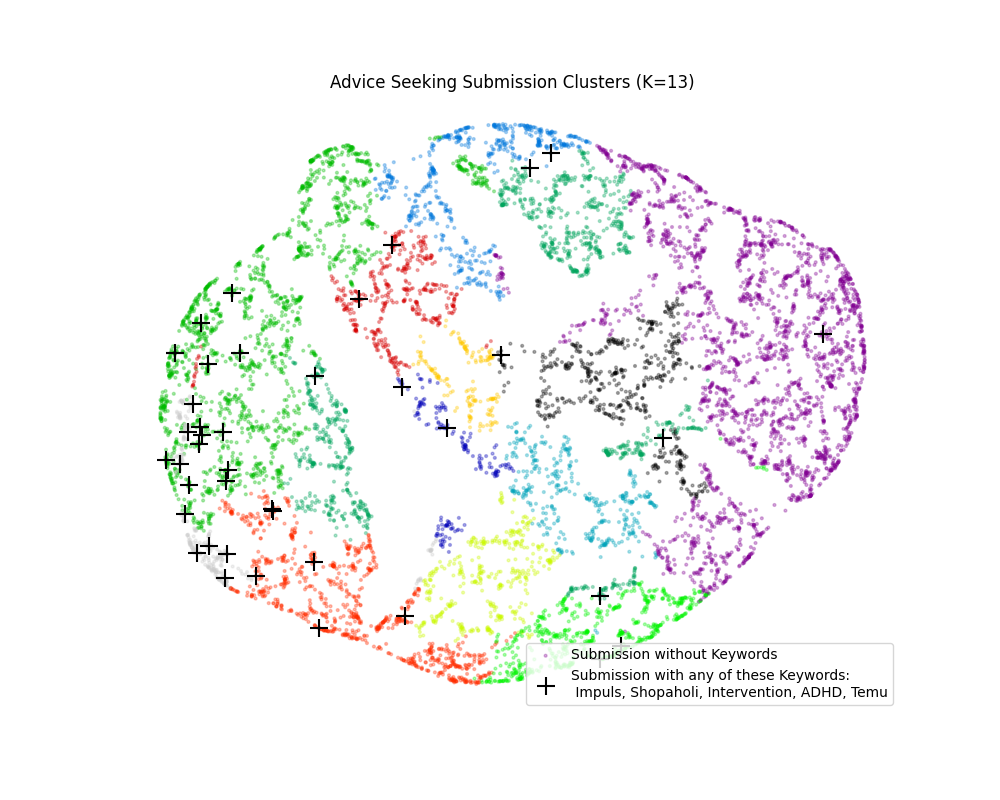

In [16]:
# visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_advice_seeking['cluster'], cmap='nipy_spectral', s=4, alpha=0.3, marker='o', label='Submission without Keywords')

# plot the comments with keywords
df_advice_seeking_with_keywords = df_advice_seeking[df_advice_seeking['has_keyword']]
embeddings_2d_with_keywords = df_advice_seeking_with_keywords['embedding_2d'].to_list()
print(embeddings_2d_with_keywords[:2])
# load with np
embeddings_2d_with_keywords = np.array(embeddings_2d_with_keywords)

# print(embeddings_2d_with_keywords[:2])
xs = embeddings_2d_with_keywords[:, 0]
ys = embeddings_2d_with_keywords[:, 1]

ax.scatter(xs, ys, cmap='nipy_spectral', s=150, alpha=1, marker='+', c='black', label=f"Submission with any of these Keywords:\n {', '.join(KEYWORDS)}")

ax.set_title(f"Advice Seeking Submission Clusters (K={clusters})", fontsize=12)
# set subtitle
crs = cursor(ax, hover=True, highlight=True)

crs.connect("add", lambda sel: select_annotation(sel, df_advice_seeking, alt_df=df_advice_seeking_with_keywords))

# remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# legend
ax.legend()

# save the plot
plt.savefig(f"{LOCATION_PROCESSED}/kmeans_clusters_submission_advice_seeking.png")

plt.show()
